# Brain tumour MRI classification

https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

See also: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
import cv2
import imutils
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
download_data = False

if download_data:
    !wget https://github.com/MichaelAllen1966/1909_brain_tumour/raw/master/data.zip
    !mkdir data
    !unzip data.zip -d data

## Load images

In [3]:
import cv2
import os

labels = ['yes', 'no']
X = []
y = []

for label in labels:
    path = './data/' + label
    for file in os.listdir(path):
                if not file.startswith('.'):
                    # Using 0 flag to read image in grayscale mode 
                    img = cv2.imread(path + '/' + file, 0)
                    X.append(img)
                    y.append(label)
                    
print(f'{len(X)} images loaded.')

253 images loaded.


## Crop images

In [4]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #gray = cv2.GaussianBlur(gray, (5, 5), 0)
        gray = cv2.GaussianBlur(img, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return set_new

In [5]:
X = crop_imgs(X)

## Resize images

In [6]:
IMG_SIZE = (224, 224)

In [7]:
def resize_imgs(set_name, img_size=(100,100)):
    """
    Resize
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(img)
    return np.array(set_new)

In [8]:
X = resize_imgs(X, (224,224))

## Show image

In [9]:
def plot_image(img):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(img, cmap='binary')
    ax.set_axis_off()
    plt.show()    

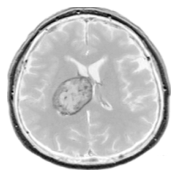

In [10]:
# Show tumour (first image)
plot_image(X[0])

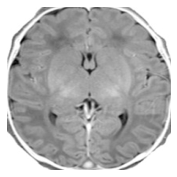

In [11]:
# Show  notumour (last image)
plot_image(X[-1])

## Split into training and test

In [12]:
# Turn y into binary label
y = np.array([1 if label == 'yes' else 0 for label in y])
# Reshape X to have 1 channel
X = X.reshape(X.shape[0], IMG_SIZE[0], IMG_SIZE[1], 1)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf

In [14]:
# ToDo Augment with keras ImageDataGenerator

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

In [17]:
datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

train_generator = datagen.flow(X_train, y_train)

In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=50,
                                                  restore_best_weights=True)

# Steps per epoch is number of batches generator produces 
batch_size = 16
steps_per_epoch = int(len(y_train) / batch_size) + 1

history = model.fit(train_generator,
                    steps_per_epoch=20,
                    epochs=250,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping_cb],
                    verbose=1)

Epoch 1/250
20/20 [==============================] - 9s 435ms/step - loss: 53.3289 - accuracy: 0.5420 - val_loss: 0.6633 - val_accuracy: 0.6719
Epoch 2/250
20/20 [==============================] - 2s 95ms/step - loss: 0.6438 - accuracy: 0.6498 - val_loss: 0.6273 - val_accuracy: 0.6719
Epoch 3/250
20/20 [==============================] - 2s 86ms/step - loss: 0.6132 - accuracy: 0.6927 - val_loss: 0.5989 - val_accuracy: 0.6562
Epoch 4/250
20/20 [==============================] - 2s 91ms/step - loss: 0.5567 - accuracy: 0.7353 - val_loss: 0.5371 - val_accuracy: 0.7031
Epoch 5/250
20/20 [==============================] - 2s 89ms/step - loss: 1.4059 - accuracy: 0.6371 - val_loss: 0.5812 - val_accuracy: 0.7031
Epoch 6/250
20/20 [==============================] - 2s 90ms/step - loss: 0.8543 - accuracy: 0.7436 - val_loss: 2.8836 - val_accuracy: 0.5625
Epoch 7/250
20/20 [==============================] - 2s 92ms/step - loss: 0.6789 - accuracy: 0.7258 - val_loss: 0.7145 - val_accuracy: 0.5781
Epoc

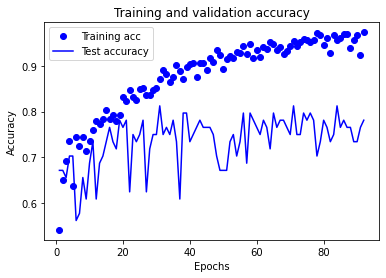

In [19]:
history_dict = history.history

import matplotlib.pyplot as plt
%matplotlib inline

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
probability = model.predict(X_test)
y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)

In [21]:
accuracy_test

0.765625

# Show an example of a missed tumour

In [22]:
# Get misseed tumours

missed = (y_pred_test == 0) & (y_test == 1)

In [23]:
missed_index = [i for i in range(len(missed)) if missed[i]]
missed_index

[0, 7, 18, 30, 37, 53, 54]

In [24]:
example = X_test[missed_index[0]]
example = example.reshape(example.shape[0], example.shape[1])

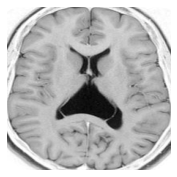

In [25]:
plot_image(example)

## Show positive rates

In [26]:
y_test.mean()

0.5625

In [27]:
y_pred_test.mean()

0.578125

## Some thing To Try .....


* More accuracy measurement (e.g. sensitivity/specificity)
* Plot a range of positve and negative images
* ROC
* Try changing net parameters, layers
* Change image resolution
* Transfer learning, e.g. see https://www.kaggle.com/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16